In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import wandb
from openretina.dataloaders import dataloaders_from_dictionaries
from openretina.hoefling_2022_configs import model_config, trainer_config
from openretina.hoefling_2022_models import SFB3d_core_SxF3d_readout
from openretina.misc import CustomPrettyPrinter
from openretina.training import standard_early_stop_trainer as trainer

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4)

In [2]:
wandb.login()
run = wandb.init(
    project="hoefling_2022_reproduction",
    notes="Testing Gaussian readout function",
)

wandb.config.update({**model_config, **trainer_config})

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: fede_dagos. Use `wandb login --relogin` to force relogin


In [3]:
!ls /Data/fd_export

dataloaders_stim_8c18928_responses_99c71a0.pkl	movies_8c18928.pkl
dataloaders_stim_c285329_responses_0698360.pkl	movies_c285329.pkl
dataloaders_stim_c285329_responses_483c12d.pkl


In [4]:
stim_dataloaders_dict = pickle.load(open("/Data/fd_export/dataloaders_stim_8c18928_responses_99c71a0.pkl", "rb"))
movies_dict = pickle.load(open("/Data/fd_export/movies_8c18928.pkl", "rb"))

In [5]:
dataloaders = dataloaders_from_dictionaries(stim_dataloaders_dict, movies_dict)
model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=dataloaders, seed=42)

{'1_ventral1_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 86])}, '2_ventral1_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 65])}, '1_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 90])}, '2_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 95])}, '3_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 115])}, '4_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 77])}, '5_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 83])}, '1_ventral1_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 69])}, '1_ventral2_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 103])}, '2_ventral2_20210930': {'inputs': torch.Size([32, 2,

/Projects/open-retina/openretina/hoefling_2022_models.py:894: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  mask = STSeparableBatchConv3d.mask_tf(time.T, stretches, T)


In [6]:
test_score, val_score, output, model_state = trainer(
    model=model,
    dataloaders=dataloaders,
    seed=1000,
    **trainer_config,
    wandb_logger=None,
)

Random seed 1000 has been set.


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
test_score

0.4860428092826126

In [8]:
val_score

0.23746182062687018

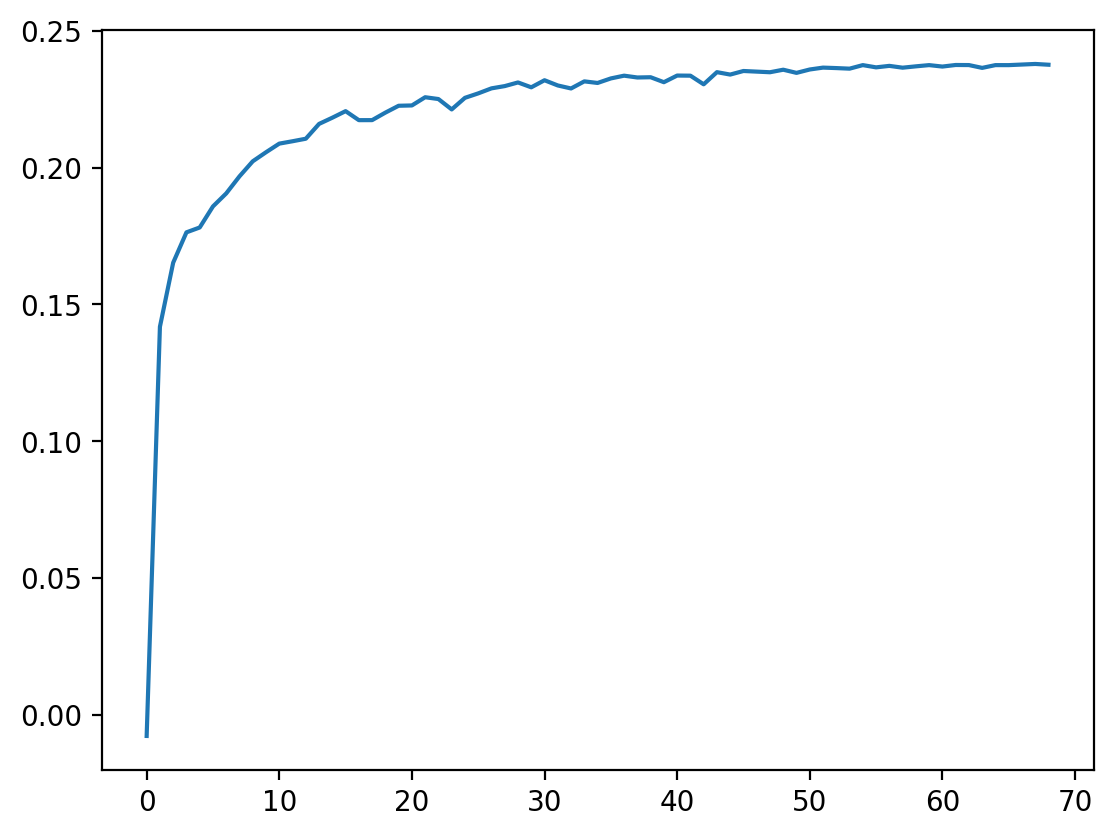

In [9]:
plt.plot(output["val_correlation"])

In [10]:
val_field = "1_ventral1_20210929"
val_sample = next(iter(dataloaders["validation"][val_field]))

In [11]:
input_samples = val_sample.inputs
targets = val_sample.targets

In [12]:
input_samples.shape

torch.Size([15, 2, 150, 18, 16])

In [13]:
with torch.no_grad():
    reconstructions = model(input_samples.to("cuda:0"), val_field)

In [14]:
reconstructions = reconstructions.cpu().numpy().squeeze()
targets = targets.cpu().numpy().squeeze()

In [15]:
targets.shape

(15, 150, 86)

In [16]:
reconstructions.shape

(15, 120, 86)

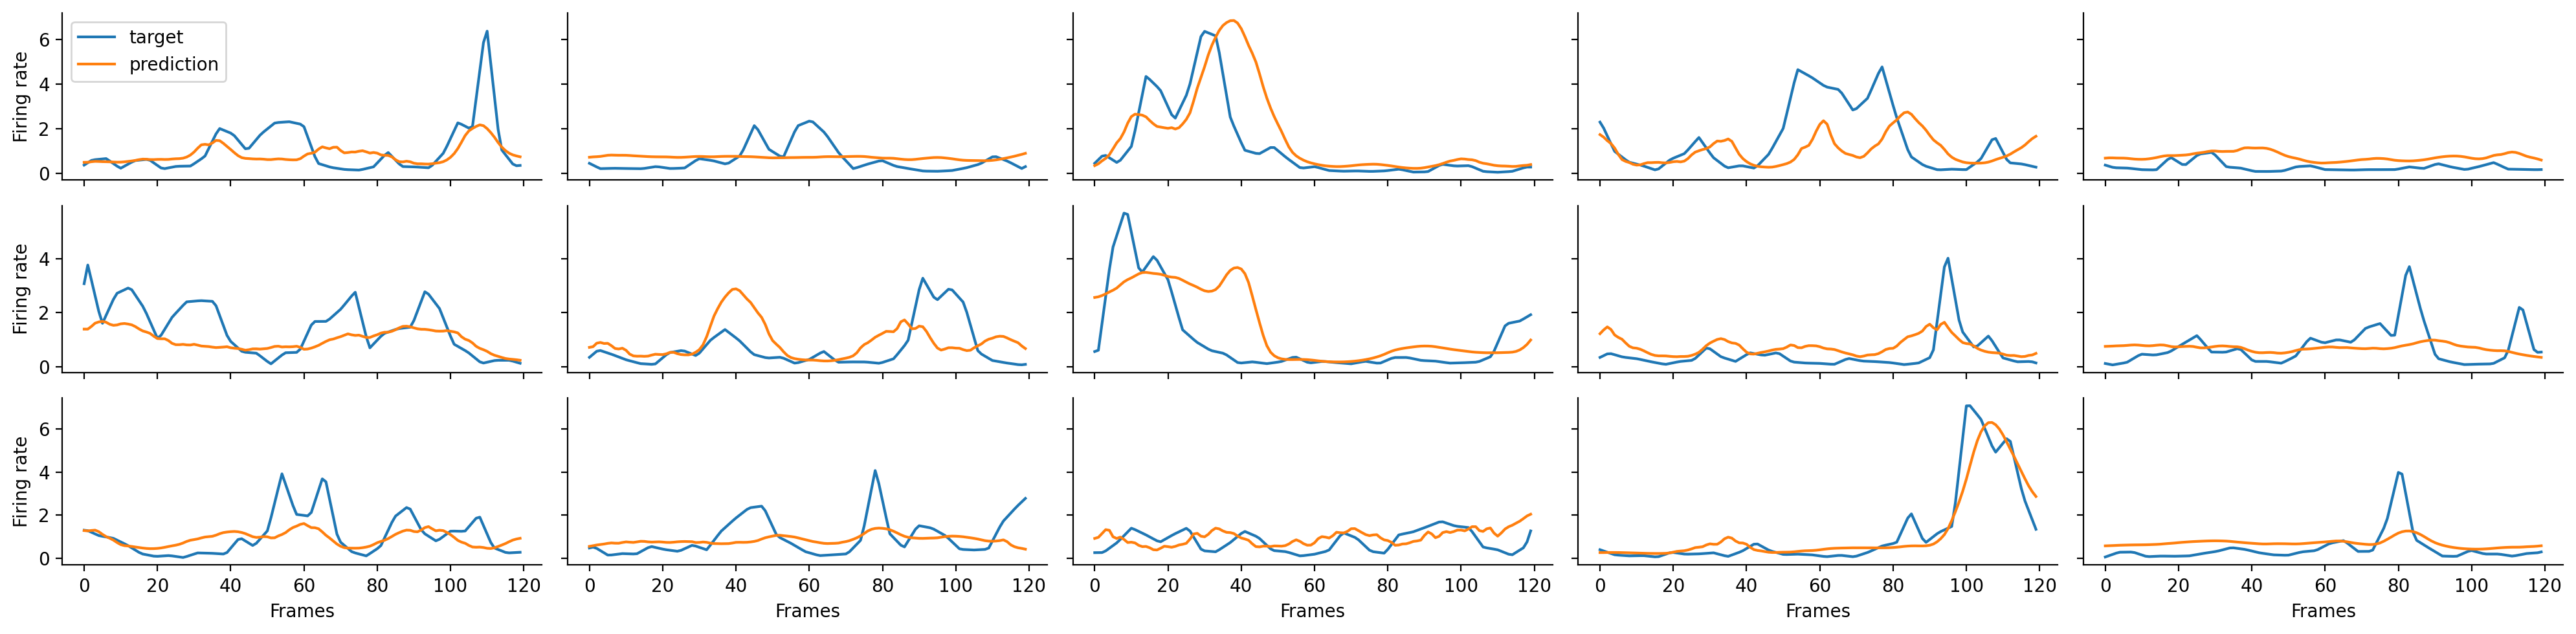

In [17]:
# Your existing code for plotting
neuron = 1
fig, axes = plt.subplots(3, 5, figsize=(20, 5), sharey="row", sharex="col")
for trace_chunk in range(targets.shape[0]):
    ax_idx_1 = trace_chunk // 5
    ax_idx_2 = trace_chunk % 5
    ax = axes[ax_idx_1, ax_idx_2]
    ax.plot(targets[trace_chunk, 30:, neuron], label="target")
    ax.plot(reconstructions[trace_chunk, :, neuron], label="prediction")

    # Set x and y labels for only outer subplots
    if ax_idx_1 == 2:  # Bottom row
        ax.set_xlabel("Frames")
    if ax_idx_2 == 0:  # Leftmost column
        ax.set_ylabel("Firing rate")

    # # Remove inner labels
    # if ax_idx_1 != 2:
    #     ax.set_xticklabels([])
    # if ax_idx_2 != 0:
    #     ax.set_yticklabels([])
    # Only turn on x-axis labels for the bottom row
    if ax_idx_1 == 2:
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)

    # Only turn on y-axis labels for the leftmost column
    if ax_idx_2 == 0:
        ax.tick_params(labelleft=True)
    else:
        ax.tick_params(labelleft=False)

# Place the legend outside of the subplots
axes[0, 0].legend()

sns.despine()

# wandb.log({"reconstruction": fig})
plt.tight_layout()

In [18]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
